## Variable that changed a lot

In [1]:
Model_name = "VGG16"

run_num  = "3"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [2]:
tensor_baord_variable, path

('VGG16_3', 'CheckPoints/VGG16_3')

## Check the working environment

In [3]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [4]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [5]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [6]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [7]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [8]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [11]:
import os

In [12]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [13]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [14]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [19]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [20]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [21]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [22]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpeg', 'jpg'}


### Check corrupted images 

In [23]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [24]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [25]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [26]:
import matplotlib.pyplot as plt

In [27]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

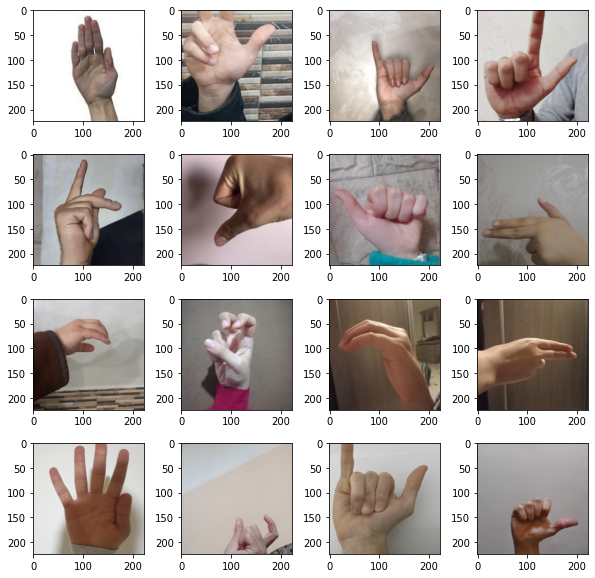

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [31]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [32]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [33]:
from collections import Counter
import numpy as np

In [34]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [35]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [36]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

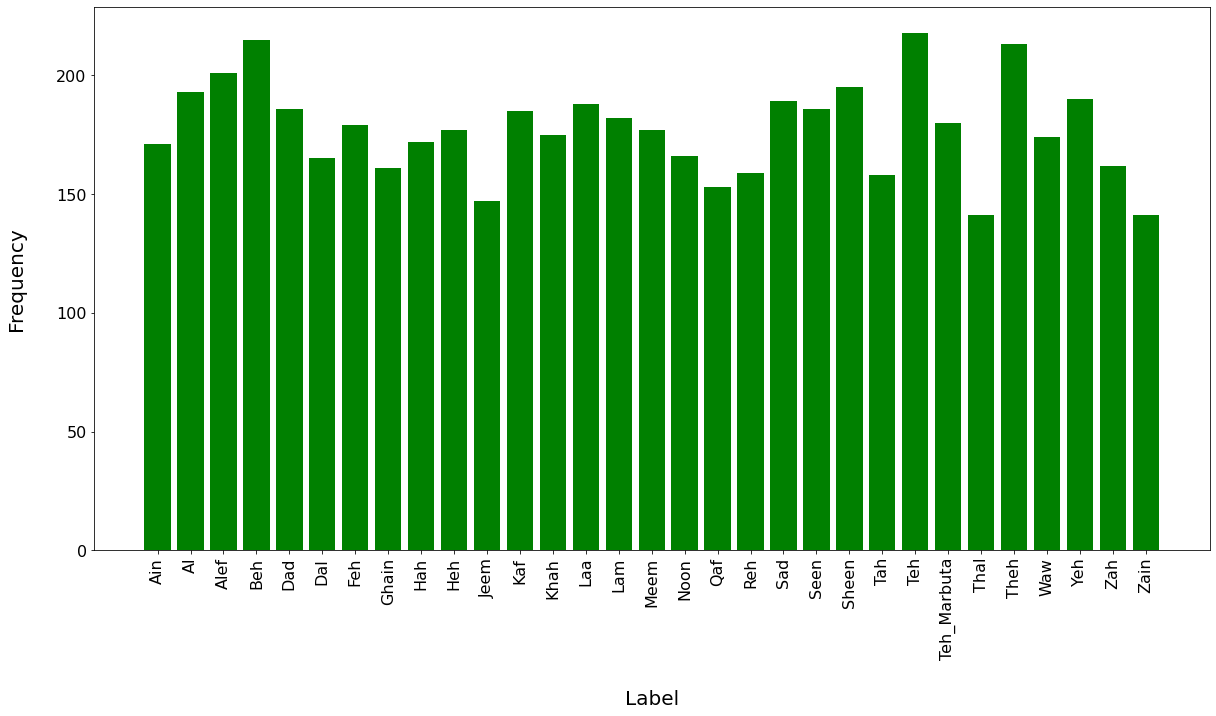

In [37]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

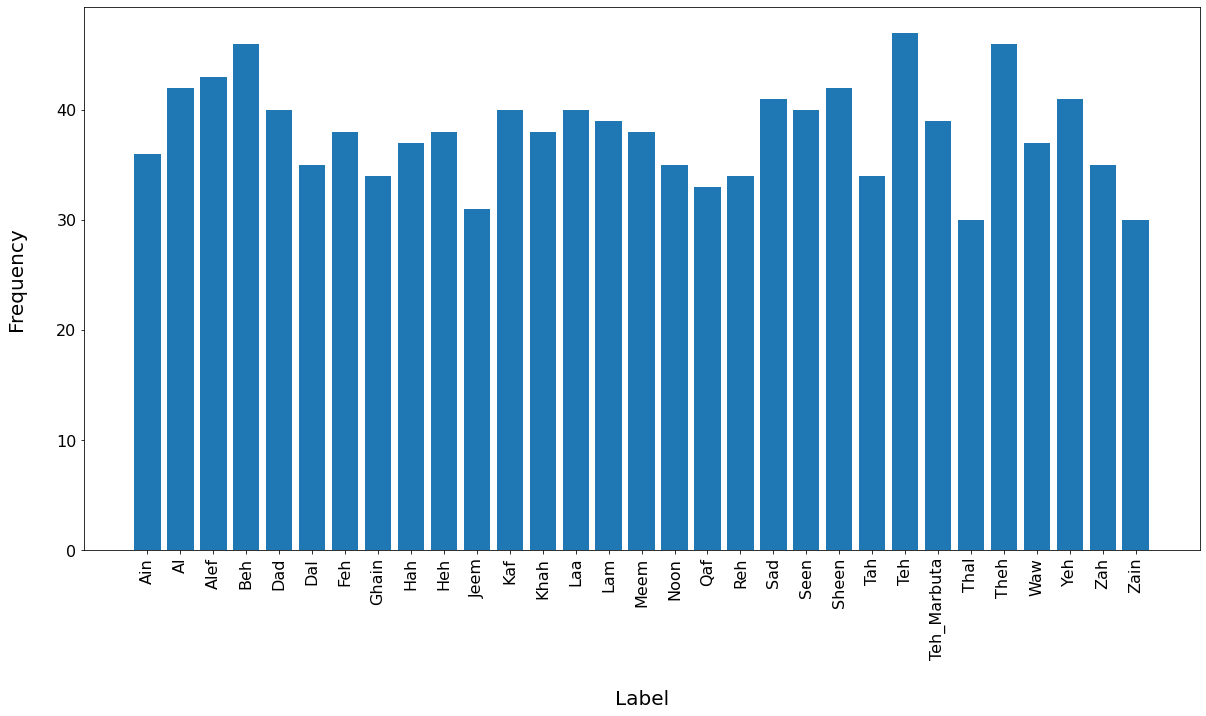

In [38]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

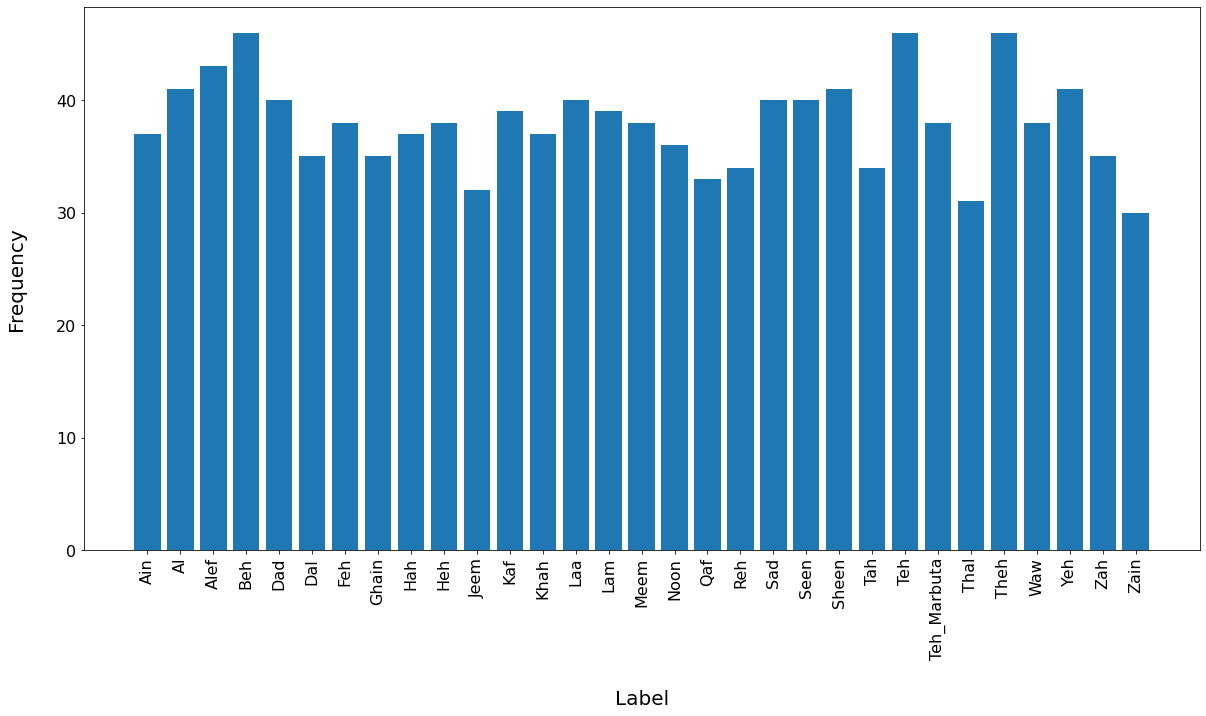

In [39]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [40]:
import torchvision.models as models
import torch.nn.functional as F

In [41]:
class Model(nn.Module):

    def __init__(self, in_channels=3, num_class =31 ):
        super(Model, self).__init__()

        self.model = models.vgg16(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False

        num_ftrs = self.model.classifier[6].in_features
                
        features = list(self.model.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_ftrs, num_class)]) # Add our layer with 4 outputs
        self.model.classifier = nn.Sequential(*features) # Replace the model classifier

        print(self.model.classifier[6].out_features)
        
    def forward(self, x):
        return self.model(x)

model = Model()

31


In [42]:
# Move the model to the device
model.to(device)

Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

### Check the gradient of layers of ResNet-18

In [43]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers


## Define a Loss function and optimizer

In [44]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.01)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [45]:
from tqdm import tqdm 

### Model training & Validation

In [46]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [47]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [48]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [49]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [50]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  3.07708454, Avg training accuracy :  16.63074046%




Epoch 1, Avg validation loss: 2.70005012, Avg validation accuracy : 32.31603205%


The best validation Loss is  2.700050115585327
The Current Accuracy of validation is  32.3160320520401

Validation loss decreased (inf --> 2.700050).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  2.54485703, Avg training accuracy :  32.29361773%




Epoch 2, Avg validation loss: 2.34456658, Avg validation accuracy : 42.44943857%


The best validation Loss is  2.344566583633423
The Current Accuracy of validation is  42.44943857192993

Validation loss decreased (2.700050 --> 2.344567).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  2.25657964, Avg training accuracy :  39.24480379%




Epoch 3, Avg validation loss: 2.14462161, Avg validation accuracy : 46.53995931%


The best validation Loss is  2.1446216106414795
The Current Accuracy of validation is  46.53995931148529

Validation loss decreased (2.344567 --> 2.144622).  Saving model ...



Epoch 4/300,  Step [86/86], Avg training loss:  2.10202575, Avg training accuracy :  42.39258766%




Epoch 4, Avg validation loss: 2.01093483, Avg validation accuracy : 48.56542349%


The best validation Loss is  2.010934829711914
The Current Accuracy of validation is  48.56542348861694

Validation loss decreased (2.144622 --> 2.010935).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  1.97146642, Avg training accuracy :  46.01430297%




Epoch 5, Avg validation loss: 1.90816557, Avg validation accuracy : 50.53910613%


The best validation Loss is  1.9081655740737915
The Current Accuracy of validation is  50.539106130599976

Validation loss decreased (2.010935 --> 1.908166).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  1.88936353, Avg training accuracy :  47.20726907%




Epoch 6, Avg validation loss: 1.83709693, Avg validation accuracy : 51.91581249%


The best validation Loss is  1.837096929550171
The Current Accuracy of validation is  51.915812492370605

Validation loss decreased (1.908166 --> 1.837097).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  1.80985212, Avg training accuracy :  49.10450280%




Epoch 7, Avg validation loss: 1.78103733, Avg validation accuracy : 52.29653716%


The best validation Loss is  1.7810373306274414
The Current Accuracy of validation is  52.29653716087341

Validation loss decreased (1.837097 --> 1.781037).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  1.75633228, Avg training accuracy :  49.86296296%




Epoch 8, Avg validation loss: 1.73046792, Avg validation accuracy : 54.08443213%


The best validation Loss is  1.7304679155349731
The Current Accuracy of validation is  54.08443212509155

Validation loss decreased (1.781037 --> 1.730468).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  1.72203207, Avg training accuracy :  50.82898140%




Epoch 9, Avg validation loss: 1.69596303, Avg validation accuracy : 53.14936638%


The best validation Loss is  1.6959630250930786
The Current Accuracy of validation is  53.14936637878418

Validation loss decreased (1.730468 --> 1.695963).  Saving model ...



Epoch 10/300,  Step [86/86], Avg training loss:  1.68117201, Avg training accuracy :  51.31953359%




Epoch 10, Avg validation loss: 1.66069329, Avg validation accuracy : 54.21844125%


The best validation Loss is  1.6606932878494263
The Current Accuracy of validation is  54.21844124794006

Validation loss decreased (1.695963 --> 1.660693).  Saving model ...



Epoch 11/300,  Step [86/86], Avg training loss:  1.65350127, Avg training accuracy :  52.86694169%




Epoch 11, Avg validation loss: 1.63249397, Avg validation accuracy : 54.21844125%


The best validation Loss is  1.6324939727783203
The Current Accuracy of validation is  54.21844124794006

Validation loss decreased (1.660693 --> 1.632494).  Saving model ...



Epoch 12/300,  Step [86/86], Avg training loss:  1.62163317, Avg training accuracy :  53.06525826%




Epoch 12, Avg validation loss: 1.60775518, Avg validation accuracy : 55.53423166%


The best validation Loss is  1.607755184173584
The Current Accuracy of validation is  55.534231662750244

Validation loss decreased (1.632494 --> 1.607755).  Saving model ...



Epoch 13/300,  Step [86/86], Avg training loss:  1.59226704, Avg training accuracy :  54.29610610%




Epoch 13, Avg validation loss: 1.58266366, Avg validation accuracy : 55.53423166%


The best validation Loss is  1.582663655281067
The Current Accuracy of validation is  55.534231662750244

Validation loss decreased (1.607755 --> 1.582664).  Saving model ...



Epoch 14/300,  Step [86/86], Avg training loss:  1.57087791, Avg training accuracy :  53.55119109%




Epoch 14, Avg validation loss: 1.56376004, Avg validation accuracy : 55.97587824%


The best validation Loss is  1.5637600421905518
The Current Accuracy of validation is  55.97587823867798

Validation loss decreased (1.582664 --> 1.563760).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  1.55552638, Avg training accuracy :  54.26746607%




Epoch 15, Avg validation loss: 1.54248214, Avg validation accuracy : 56.60331249%


The best validation Loss is  1.5424821376800537
The Current Accuracy of validation is  56.603312492370605

Validation loss decreased (1.563760 --> 1.542482).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  1.53980505, Avg training accuracy :  55.45305014%




Epoch 16, Avg validation loss: 1.53011632, Avg validation accuracy : 56.43883944%


The best validation Loss is  1.530116319656372
The Current Accuracy of validation is  56.43883943557739

Validation loss decreased (1.542482 --> 1.530116).  Saving model ...



Epoch 17/300,  Step [86/86], Avg training loss:  1.50003624, Avg training accuracy :  55.78008294%




Epoch 17, Avg validation loss: 1.51392758, Avg validation accuracy : 57.04495907%


The best validation Loss is  1.5139275789260864
The Current Accuracy of validation is  57.04495906829834

Validation loss decreased (1.530116 --> 1.513928).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  1.49587250, Avg training accuracy :  55.41055202%




Epoch 18, Avg validation loss: 1.49928343, Avg validation accuracy : 57.09673166%


The best validation Loss is  1.4992834329605103
The Current Accuracy of validation is  57.096731662750244

Validation loss decreased (1.513928 --> 1.499283).  Saving model ...



Epoch 19/300,  Step [86/86], Avg training loss:  1.48288858, Avg training accuracy :  55.68923950%




Epoch 19, Avg validation loss: 1.48231328, Avg validation accuracy : 57.04495907%


The best validation Loss is  1.4823132753372192
The Current Accuracy of validation is  57.04495906829834

Validation loss decreased (1.499283 --> 1.482313).  Saving model ...



Epoch 20/300,  Step [86/86], Avg training loss:  1.46931803, Avg training accuracy :  56.25677109%




Epoch 20, Avg validation loss: 1.47600996, Avg validation accuracy : 57.70285130%


The best validation Loss is  1.4760099649429321
The Current Accuracy of validation is  57.70285129547119

Validation loss decreased (1.482313 --> 1.476010).  Saving model ...



Epoch 21/300,  Step [86/86], Avg training loss:  1.45258296, Avg training accuracy :  57.45313168%




Epoch 21, Avg validation loss: 1.46203327, Avg validation accuracy : 57.78508782%


The best validation Loss is  1.4620332717895508
The Current Accuracy of validation is  57.7850878238678

Validation loss decreased (1.476010 --> 1.462033).  Saving model ...



Epoch 22/300,  Step [86/86], Avg training loss:  1.42620790, Avg training accuracy :  58.08133483%




Epoch 22, Avg validation loss: 1.45163250, Avg validation accuracy : 57.83686638%


The best validation Loss is  1.4516324996948242
The Current Accuracy of validation is  57.83686637878418

Validation loss decreased (1.462033 --> 1.451632).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  1.42784894, Avg training accuracy :  57.70748854%




Epoch 23, Avg validation loss: 1.44181359, Avg validation accuracy : 57.53837824%


The best validation Loss is  1.441813588142395
The Current Accuracy of validation is  57.53837823867798

Validation loss decreased (1.451632 --> 1.441814).  Saving model ...



Epoch 24/300,  Step [86/86], Avg training loss:  1.42543721, Avg training accuracy :  57.21386075%




Epoch 24, Avg validation loss: 1.43224180, Avg validation accuracy : 58.36074948%


The best validation Loss is  1.4322417974472046
The Current Accuracy of validation is  58.36074948310852

Validation loss decreased (1.441814 --> 1.432242).  Saving model ...



Epoch 25/300,  Step [86/86], Avg training loss:  1.41054165, Avg training accuracy :  57.47869015%




Epoch 25, Avg validation loss: 1.42854404, Avg validation accuracy : 58.24804902%


The best validation Loss is  1.428544044494629
The Current Accuracy of validation is  58.24804902076721

Validation loss decreased (1.432242 --> 1.428544).  Saving model ...



Epoch 26/300,  Step [86/86], Avg training loss:  1.39696622, Avg training accuracy :  58.10566545%




Epoch 26, Avg validation loss: 1.42073905, Avg validation accuracy : 58.08357596%


The best validation Loss is  1.4207390546798706
The Current Accuracy of validation is  58.083575963974

Validation loss decreased (1.428544 --> 1.420739).  Saving model ...



Epoch 27/300,  Step [86/86], Avg training loss:  1.40185821, Avg training accuracy :  57.63635635%




Epoch 27, Avg validation loss: 1.41377556, Avg validation accuracy : 58.16581249%


The best validation Loss is  1.4137755632400513
The Current Accuracy of validation is  58.165812492370605

Validation loss decreased (1.420739 --> 1.413776).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  1.38060820, Avg training accuracy :  59.03071761%




Epoch 28, Avg validation loss: 1.40776181, Avg validation accuracy : 58.93640518%


The best validation Loss is  1.407761812210083
The Current Accuracy of validation is  58.936405181884766

Validation loss decreased (1.413776 --> 1.407762).  Saving model ...



Epoch 29/300,  Step [86/86], Avg training loss:  1.37751389, Avg training accuracy :  57.63019919%




Epoch 29, Avg validation loss: 1.40075159, Avg validation accuracy : 59.15265083%


The best validation Loss is  1.4007515907287598
The Current Accuracy of validation is  59.15265083312988

Validation loss decreased (1.407762 --> 1.400752).  Saving model ...



Epoch 30/300,  Step [86/86], Avg training loss:  1.36858106, Avg training accuracy :  58.23592544%




Epoch 30, Avg validation loss: 1.39347875, Avg validation accuracy : 59.39936638%


The best validation Loss is  1.3934787511825562
The Current Accuracy of validation is  59.39936637878418

Validation loss decreased (1.400752 --> 1.393479).  Saving model ...



Epoch 31/300,  Step [86/86], Avg training loss:  1.36415029, Avg training accuracy :  58.35540295%




Epoch 31, Avg validation loss: 1.38781643, Avg validation accuracy : 58.71101022%


The best validation Loss is  1.3878164291381836
The Current Accuracy of validation is  58.711010217666626

Validation loss decreased (1.393479 --> 1.387816).  Saving model ...



Epoch 32/300,  Step [86/86], Avg training loss:  1.36434555, Avg training accuracy :  59.02332664%




Epoch 32, Avg validation loss: 1.38266504, Avg validation accuracy : 59.46028233%


The best validation Loss is  1.3826650381088257
The Current Accuracy of validation is  59.46028232574463

Validation loss decreased (1.387816 --> 1.382665).  Saving model ...



Epoch 33/300,  Step [86/86], Avg training loss:  1.35007823, Avg training accuracy :  58.76281261%




Epoch 33, Avg validation loss: 1.37628901, Avg validation accuracy : 59.51206088%


The best validation Loss is  1.3762890100479126
The Current Accuracy of validation is  59.51206088066101

Validation loss decreased (1.382665 --> 1.376289).  Saving model ...



Epoch 34/300,  Step [86/86], Avg training loss:  1.33754730, Avg training accuracy :  59.63644385%




Epoch 34, Avg validation loss: 1.37531948, Avg validation accuracy : 60.00548601%


The best validation Loss is  1.375319480895996
The Current Accuracy of validation is  60.00548601150513

Validation loss decreased (1.376289 --> 1.375319).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  1.33339918, Avg training accuracy :  58.99438262%




Epoch 35, Avg validation loss: 1.36885107, Avg validation accuracy : 60.00548601%


The best validation Loss is  1.3688510656356812
The Current Accuracy of validation is  60.00548601150513

Validation loss decreased (1.375319 --> 1.368851).  Saving model ...



Epoch 36/300,  Step [86/86], Avg training loss:  1.31395578, Avg training accuracy :  60.57043076%




Epoch 36, Avg validation loss: 1.36501980, Avg validation accuracy : 59.64607596%


The best validation Loss is  1.3650197982788086
The Current Accuracy of validation is  59.646075963974

Validation loss decreased (1.368851 --> 1.365020).  Saving model ...



Epoch 37/300,  Step [86/86], Avg training loss:  1.32582462, Avg training accuracy :  59.69556570%




Epoch 37, Avg validation loss: 1.36261523, Avg validation accuracy : 59.39936638%


The best validation Loss is  1.3626152276992798
The Current Accuracy of validation is  59.39936637878418

Validation loss decreased (1.365020 --> 1.362615).  Saving model ...



Epoch 38/300,  Step [86/86], Avg training loss:  1.31764221, Avg training accuracy :  59.06551480%




Epoch 38, Avg validation loss: 1.35975671, Avg validation accuracy : 59.72831249%


The best validation Loss is  1.3597567081451416
The Current Accuracy of validation is  59.728312492370605

Validation loss decreased (1.362615 --> 1.359757).  Saving model ...



Epoch 39/300,  Step [86/86], Avg training loss:  1.29481912, Avg training accuracy :  60.23446918%




Epoch 39, Avg validation loss: 1.35401225, Avg validation accuracy : 60.33443213%


The best validation Loss is  1.3540122509002686
The Current Accuracy of validation is  60.33443212509155

Validation loss decreased (1.359757 --> 1.354012).  Saving model ...



Epoch 40/300,  Step [86/86], Avg training loss:  1.28885472, Avg training accuracy :  60.94304323%




Epoch 40, Avg validation loss: 1.34876156, Avg validation accuracy : 60.16995907%


The best validation Loss is  1.3487615585327148
The Current Accuracy of validation is  60.16995906829834

Validation loss decreased (1.354012 --> 1.348762).  Saving model ...



Epoch 41/300,  Step [86/86], Avg training loss:  1.29496717, Avg training accuracy :  60.40106416%




Epoch 41, Avg validation loss: 1.34471571, Avg validation accuracy : 60.94054580%


The best validation Loss is  1.3447157144546509
The Current Accuracy of validation is  60.94054579734802

Validation loss decreased (1.348762 --> 1.344716).  Saving model ...



Epoch 42/300,  Step [86/86], Avg training loss:  1.30024672, Avg training accuracy :  60.05123854%




Epoch 42, Avg validation loss: 1.34346294, Avg validation accuracy : 60.94054580%


The best validation Loss is  1.3434629440307617
The Current Accuracy of validation is  60.94054579734802

Validation loss decreased (1.344716 --> 1.343463).  Saving model ...



Epoch 43/300,  Step [86/86], Avg training loss:  1.28251386, Avg training accuracy :  61.14289761%




Epoch 43, Avg validation loss: 1.33621466, Avg validation accuracy : 61.18725538%


The best validation Loss is  1.3362146615982056
The Current Accuracy of validation is  61.18725538253784

Validation loss decreased (1.343463 --> 1.336215).  Saving model ...



Epoch 44/300,  Step [86/86], Avg training loss:  1.28191483, Avg training accuracy :  60.58121324%




Epoch 44, Avg validation loss: 1.33098567, Avg validation accuracy : 60.82785130%


The best validation Loss is  1.33098566532135
The Current Accuracy of validation is  60.82785129547119

Validation loss decreased (1.336215 --> 1.330986).  Saving model ...



Epoch 45/300,  Step [86/86], Avg training loss:  1.26826739, Avg training accuracy :  60.44787169%




Epoch 45, Avg validation loss: 1.32766116, Avg validation accuracy : 60.77607274%


The best validation Loss is  1.327661156654358
The Current Accuracy of validation is  60.77607274055481

Validation loss decreased (1.330986 --> 1.327661).  Saving model ...



Epoch 46/300,  Step [86/86], Avg training loss:  1.29127610, Avg training accuracy :  61.02002859%




Epoch 46, Avg validation loss: 1.32885969, Avg validation accuracy : 60.22173166%

EarlyStopping counter: 1 out of 10



Epoch 47/300,  Step [86/86], Avg training loss:  1.27848625, Avg training accuracy :  61.17307544%




Epoch 47, Avg validation loss: 1.32323802, Avg validation accuracy : 60.66337824%


The best validation Loss is  1.3232380151748657
The Current Accuracy of validation is  60.66337823867798

Validation loss decreased (1.327661 --> 1.323238).  Saving model ...



Epoch 48/300,  Step [86/86], Avg training loss:  1.27962160, Avg training accuracy :  60.35857201%




Epoch 48, Avg validation loss: 1.32693565, Avg validation accuracy : 60.33443213%

EarlyStopping counter: 1 out of 10



Epoch 49/300,  Step [86/86], Avg training loss:  1.24964988, Avg training accuracy :  62.15879917%




Epoch 49, Avg validation loss: 1.31509888, Avg validation accuracy : 61.02278233%


The best validation Loss is  1.3150988817214966
The Current Accuracy of validation is  61.02278232574463

Validation loss decreased (1.323238 --> 1.315099).  Saving model ...



Epoch 50/300,  Step [86/86], Avg training loss:  1.24620378, Avg training accuracy :  62.21330166%




Epoch 50, Avg validation loss: 1.31349480, Avg validation accuracy : 60.66337824%


The best validation Loss is  1.3134948015213013
The Current Accuracy of validation is  60.66337823867798

Validation loss decreased (1.315099 --> 1.313495).  Saving model ...



Epoch 51/300,  Step [86/86], Avg training loss:  1.24553657, Avg training accuracy :  61.84993386%




Epoch 51, Avg validation loss: 1.30746186, Avg validation accuracy : 61.35172844%


The best validation Loss is  1.3074618577957153
The Current Accuracy of validation is  61.351728439331055

Validation loss decreased (1.313495 --> 1.307462).  Saving model ...



Epoch 52/300,  Step [86/86], Avg training loss:  1.23211014, Avg training accuracy :  62.13755012%




Epoch 52, Avg validation loss: 1.30601048, Avg validation accuracy : 60.49890518%


The best validation Loss is  1.3060104846954346
The Current Accuracy of validation is  60.498905181884766

Validation loss decreased (1.307462 --> 1.306010).  Saving model ...



Epoch 53/300,  Step [86/86], Avg training loss:  1.23995996, Avg training accuracy :  62.20406890%




Epoch 53, Avg validation loss: 1.30540144, Avg validation accuracy : 61.84515357%


The best validation Loss is  1.3054014444351196
The Current Accuracy of validation is  61.84515357017517

Validation loss decreased (1.306010 --> 1.305401).  Saving model ...



Epoch 54/300,  Step [86/86], Avg training loss:  1.24057567, Avg training accuracy :  61.44714355%




Epoch 54, Avg validation loss: 1.31026495, Avg validation accuracy : 59.97502208%

EarlyStopping counter: 1 out of 10



Epoch 55/300,  Step [86/86], Avg training loss:  1.21701849, Avg training accuracy :  63.18086386%




Epoch 55, Avg validation loss: 1.30519831, Avg validation accuracy : 59.94456410%


The best validation Loss is  1.305198311805725
The Current Accuracy of validation is  59.9445641040802

Validation loss decreased (1.305401 --> 1.305198).  Saving model ...



Epoch 56/300,  Step [86/86], Avg training loss:  1.22672379, Avg training accuracy :  62.26011515%




Epoch 56, Avg validation loss: 1.29980624, Avg validation accuracy : 61.53752208%


The best validation Loss is  1.2998062372207642
The Current Accuracy of validation is  61.537522077560425

Validation loss decreased (1.305198 --> 1.299806).  Saving model ...



Epoch 57/300,  Step [86/86], Avg training loss:  1.21738517, Avg training accuracy :  62.93851137%




Epoch 57, Avg validation loss: 1.29945517, Avg validation accuracy : 60.93140841%


The best validation Loss is  1.299455165863037
The Current Accuracy of validation is  60.931408405303955

Validation loss decreased (1.299806 --> 1.299455).  Saving model ...



Epoch 58/300,  Step [86/86], Avg training loss:  1.21287584, Avg training accuracy :  62.39345670%




Epoch 58, Avg validation loss: 1.29923224, Avg validation accuracy : 60.13949513%


The best validation Loss is  1.2992322444915771
The Current Accuracy of validation is  60.13949513435364

Validation loss decreased (1.299455 --> 1.299232).  Saving model ...



Epoch 59/300,  Step [86/86], Avg training loss:  1.21541190, Avg training accuracy :  63.02042007%




Epoch 59, Avg validation loss: 1.29482114, Avg validation accuracy : 61.07456088%


The best validation Loss is  1.2948211431503296
The Current Accuracy of validation is  61.07456088066101

Validation loss decreased (1.299232 --> 1.294821).  Saving model ...



Epoch 60/300,  Step [86/86], Avg training loss:  1.21562457, Avg training accuracy :  62.91418076%




Epoch 60, Avg validation loss: 1.29871809, Avg validation accuracy : 61.01364493%

EarlyStopping counter: 1 out of 10



Epoch 61/300,  Step [86/86], Avg training loss:  1.21559858, Avg training accuracy :  62.41931915%




Epoch 61, Avg validation loss: 1.29410124, Avg validation accuracy : 60.69383621%


The best validation Loss is  1.2941012382507324
The Current Accuracy of validation is  60.6938362121582

Validation loss decreased (1.294821 --> 1.294101).  Saving model ...



Epoch 62/300,  Step [86/86], Avg training loss:  1.19971633, Avg training accuracy :  62.81749010%




Epoch 62, Avg validation loss: 1.29557455, Avg validation accuracy : 60.96186638%

EarlyStopping counter: 1 out of 10



Epoch 63/300,  Step [86/86], Avg training loss:  1.20855629, Avg training accuracy :  62.75836229%




Epoch 63, Avg validation loss: 1.28629780, Avg validation accuracy : 61.26949191%


The best validation Loss is  1.2862977981567383
The Current Accuracy of validation is  61.26949191093445

Validation loss decreased (1.294101 --> 1.286298).  Saving model ...



Epoch 64/300,  Step [86/86], Avg training loss:  1.20356262, Avg training accuracy :  63.05676103%




Epoch 64, Avg validation loss: 1.28573930, Avg validation accuracy : 61.56798601%


The best validation Loss is  1.2857393026351929
The Current Accuracy of validation is  61.56798601150513

Validation loss decreased (1.286298 --> 1.285739).  Saving model ...



Epoch 65/300,  Step [86/86], Avg training loss:  1.19327581, Avg training accuracy :  63.09309602%




Epoch 65, Avg validation loss: 1.28602505, Avg validation accuracy : 61.12633944%

EarlyStopping counter: 1 out of 10



Epoch 66/300,  Step [86/86], Avg training loss:  1.19491875, Avg training accuracy :  62.39345670%




Epoch 66, Avg validation loss: 1.28043902, Avg validation accuracy : 61.56798601%


The best validation Loss is  1.280439019203186
The Current Accuracy of validation is  61.56798601150513

Validation loss decreased (1.285739 --> 1.280439).  Saving model ...



Epoch 67/300,  Step [86/86], Avg training loss:  1.19727814, Avg training accuracy :  63.53961229%




Epoch 67, Avg validation loss: 1.28086245, Avg validation accuracy : 61.12633944%

EarlyStopping counter: 1 out of 10



Epoch 68/300,  Step [86/86], Avg training loss:  1.18977869, Avg training accuracy :  63.33667636%




Epoch 68, Avg validation loss: 1.27645278, Avg validation accuracy : 61.40351295%


The best validation Loss is  1.2764527797698975
The Current Accuracy of validation is  61.403512954711914

Validation loss decreased (1.280439 --> 1.276453).  Saving model ...



Epoch 69/300,  Step [86/86], Avg training loss:  1.17835808, Avg training accuracy :  63.46848011%




Epoch 69, Avg validation loss: 1.27799904, Avg validation accuracy : 61.04410291%

EarlyStopping counter: 1 out of 10



Epoch 70/300,  Step [86/86], Avg training loss:  1.18527901, Avg training accuracy :  63.07492852%




Epoch 70, Avg validation loss: 1.27679896, Avg validation accuracy : 61.40351295%

EarlyStopping counter: 2 out of 10



Epoch 71/300,  Step [86/86], Avg training loss:  1.18367517, Avg training accuracy :  63.55777979%




Epoch 71, Avg validation loss: 1.27711606, Avg validation accuracy : 61.04410291%

EarlyStopping counter: 3 out of 10



Epoch 72/300,  Step [86/86], Avg training loss:  1.17496443, Avg training accuracy :  63.41089606%




Epoch 72, Avg validation loss: 1.27405643, Avg validation accuracy : 61.97916865%


The best validation Loss is  1.2740564346313477
The Current Accuracy of validation is  61.97916865348816

Validation loss decreased (1.276453 --> 1.274056).  Saving model ...



Epoch 73/300,  Step [86/86], Avg training loss:  1.18984234, Avg training accuracy :  63.40196133%




Epoch 73, Avg validation loss: 1.26992655, Avg validation accuracy : 61.76291704%


The best validation Loss is  1.2699265480041504
The Current Accuracy of validation is  61.762917041778564

Validation loss decreased (1.274056 --> 1.269927).  Saving model ...



Epoch 74/300,  Step [86/86], Avg training loss:  1.16727436, Avg training accuracy :  64.23463821%




Epoch 74, Avg validation loss: 1.26999426, Avg validation accuracy : 61.40351295%

EarlyStopping counter: 1 out of 10



Epoch 75/300,  Step [86/86], Avg training loss:  1.17751384, Avg training accuracy :  63.66987228%




Epoch 75, Avg validation loss: 1.26753175, Avg validation accuracy : 61.32127643%


The best validation Loss is  1.2675317525863647
The Current Accuracy of validation is  61.32127642631531

Validation loss decreased (1.269927 --> 1.267532).  Saving model ...



Epoch 76/300,  Step [86/86], Avg training loss:  1.15424562, Avg training accuracy :  64.72519040%




Epoch 76, Avg validation loss: 1.26870501, Avg validation accuracy : 61.56798601%

EarlyStopping counter: 1 out of 10



Epoch 77/300,  Step [86/86], Avg training loss:  1.16697359, Avg training accuracy :  64.01199698%




Epoch 77, Avg validation loss: 1.26886189, Avg validation accuracy : 61.68068051%

EarlyStopping counter: 2 out of 10



Epoch 78/300,  Step [86/86], Avg training loss:  1.15702665, Avg training accuracy :  63.86356950%




Epoch 78, Avg validation loss: 1.26140761, Avg validation accuracy : 61.73245907%


The best validation Loss is  1.2614076137542725
The Current Accuracy of validation is  61.73245906829834

Validation loss decreased (1.267532 --> 1.261408).  Saving model ...



Epoch 79/300,  Step [86/86], Avg training loss:  1.15405548, Avg training accuracy :  63.98181915%




Epoch 79, Avg validation loss: 1.26358771, Avg validation accuracy : 62.06140518%

EarlyStopping counter: 1 out of 10



Epoch 80/300,  Step [86/86], Avg training loss:  1.14878488, Avg training accuracy :  63.83185387%




Epoch 80, Avg validation loss: 1.26180732, Avg validation accuracy : 61.56798601%

EarlyStopping counter: 2 out of 10



Epoch 81/300,  Step [86/86], Avg training loss:  1.15426004, Avg training accuracy :  64.68885541%




Epoch 81, Avg validation loss: 1.26176989, Avg validation accuracy : 61.73245907%

EarlyStopping counter: 3 out of 10



Epoch 82/300,  Step [86/86], Avg training loss:  1.14669752, Avg training accuracy :  63.78042698%




Epoch 82, Avg validation loss: 1.25450170, Avg validation accuracy : 61.89693213%


The best validation Loss is  1.2545017004013062
The Current Accuracy of validation is  61.89693212509155

Validation loss decreased (1.261408 --> 1.254502).  Saving model ...



Epoch 83/300,  Step [86/86], Avg training loss:  1.14676392, Avg training accuracy :  64.12716508%




Epoch 83, Avg validation loss: 1.25607824, Avg validation accuracy : 62.42080927%

EarlyStopping counter: 1 out of 10



Epoch 84/300,  Step [86/86], Avg training loss:  1.13381302, Avg training accuracy :  64.88100886%




Epoch 84, Avg validation loss: 1.25660038, Avg validation accuracy : 62.09186316%

EarlyStopping counter: 2 out of 10



Epoch 85/300,  Step [86/86], Avg training loss:  1.13702273, Avg training accuracy :  65.25054574%




Epoch 85, Avg validation loss: 1.25387013, Avg validation accuracy : 62.45126724%


The best validation Loss is  1.2538701295852661
The Current Accuracy of validation is  62.45126724243164

Validation loss decreased (1.254502 --> 1.253870).  Saving model ...



Epoch 86/300,  Step [86/86], Avg training loss:  1.11747479, Avg training accuracy :  64.96446133%




Epoch 86, Avg validation loss: 1.25385511, Avg validation accuracy : 62.17409968%


The best validation Loss is  1.2538551092147827
The Current Accuracy of validation is  62.1740996837616

Validation loss decreased (1.253870 --> 1.253855).  Saving model ...



Epoch 87/300,  Step [86/86], Avg training loss:  1.13326645, Avg training accuracy :  64.88100886%




Epoch 87, Avg validation loss: 1.25527346, Avg validation accuracy : 61.89693213%

EarlyStopping counter: 1 out of 10



Epoch 88/300,  Step [86/86], Avg training loss:  1.13935375, Avg training accuracy :  64.73873854%




Epoch 88, Avg validation loss: 1.25505126, Avg validation accuracy : 61.84515357%

EarlyStopping counter: 2 out of 10



Epoch 89/300,  Step [86/86], Avg training loss:  1.13452888, Avg training accuracy :  64.30731416%




Epoch 89, Avg validation loss: 1.25420618, Avg validation accuracy : 62.91422844%

EarlyStopping counter: 3 out of 10



Epoch 90/300,  Step [86/86], Avg training loss:  1.12820411, Avg training accuracy :  64.62665200%




Epoch 90, Avg validation loss: 1.25161314, Avg validation accuracy : 61.84515357%


The best validation Loss is  1.2516131401062012
The Current Accuracy of validation is  61.84515357017517

Validation loss decreased (1.253855 --> 1.251613).  Saving model ...



Epoch 91/300,  Step [86/86], Avg training loss:  1.11597562, Avg training accuracy :  65.10827541%




Epoch 91, Avg validation loss: 1.24990308, Avg validation accuracy : 61.76291704%


The best validation Loss is  1.2499030828475952
The Current Accuracy of validation is  61.762917041778564

Validation loss decreased (1.251613 --> 1.249903).  Saving model ...



Epoch 92/300,  Step [86/86], Avg training loss:  1.13492298, Avg training accuracy :  63.86818886%




Epoch 92, Avg validation loss: 1.24589241, Avg validation accuracy : 62.63706088%


The best validation Loss is  1.2458924055099487
The Current Accuracy of validation is  62.63706088066101

Validation loss decreased (1.249903 --> 1.245892).  Saving model ...



Epoch 93/300,  Step [86/86], Avg training loss:  1.13533092, Avg training accuracy :  64.22386169%




Epoch 93, Avg validation loss: 1.24773061, Avg validation accuracy : 62.14364171%

EarlyStopping counter: 1 out of 10



Epoch 94/300,  Step [86/86], Avg training loss:  1.11515498, Avg training accuracy :  65.33984542%




Epoch 94, Avg validation loss: 1.24347079, Avg validation accuracy : 62.22587824%


The best validation Loss is  1.2434707880020142
The Current Accuracy of validation is  62.22587823867798

Validation loss decreased (1.245892 --> 1.243471).  Saving model ...



Epoch 95/300,  Step [86/86], Avg training loss:  1.11701965, Avg training accuracy :  65.18248916%




Epoch 95, Avg validation loss: 1.24221623, Avg validation accuracy : 62.66751885%


The best validation Loss is  1.2422162294387817
The Current Accuracy of validation is  62.667518854141235

Validation loss decreased (1.243471 --> 1.242216).  Saving model ...



Epoch 96/300,  Step [86/86], Avg training loss:  1.11764812, Avg training accuracy :  65.74263573%




Epoch 96, Avg validation loss: 1.24575460, Avg validation accuracy : 62.55482435%

EarlyStopping counter: 1 out of 10



Epoch 97/300,  Step [86/86], Avg training loss:  1.10451972, Avg training accuracy :  65.57911634%




Epoch 97, Avg validation loss: 1.24056661, Avg validation accuracy : 62.85331249%


The best validation Loss is  1.240566611289978
The Current Accuracy of validation is  62.853312492370605

Validation loss decreased (1.242216 --> 1.240567).  Saving model ...



Epoch 98/300,  Step [86/86], Avg training loss:  1.12145376, Avg training accuracy :  64.36797976%




Epoch 98, Avg validation loss: 1.24275029, Avg validation accuracy : 62.49390841%

EarlyStopping counter: 1 out of 10



Epoch 99/300,  Step [86/86], Avg training loss:  1.12139976, Avg training accuracy :  64.79170918%




Epoch 99, Avg validation loss: 1.24164283, Avg validation accuracy : 61.58930063%

EarlyStopping counter: 2 out of 10



Epoch 100/300,  Step [86/86], Avg training loss:  1.13009942, Avg training accuracy :  64.77661729%




Epoch 100, Avg validation loss: 1.24018002, Avg validation accuracy : 62.47258782%


The best validation Loss is  1.2401800155639648
The Current Accuracy of validation is  62.4725878238678

Validation loss decreased (1.240567 --> 1.240180).  Saving model ...



Epoch 101/300,  Step [86/86], Avg training loss:  1.08563566, Avg training accuracy :  66.13771915%




Epoch 101, Avg validation loss: 1.23663461, Avg validation accuracy : 61.61975861%


The best validation Loss is  1.236634612083435
The Current Accuracy of validation is  61.61975860595703

Validation loss decreased (1.240180 --> 1.236635).  Saving model ...



Epoch 102/300,  Step [86/86], Avg training loss:  1.11242068, Avg training accuracy :  65.39589167%




Epoch 102, Avg validation loss: 1.24139011, Avg validation accuracy : 61.56798601%

EarlyStopping counter: 1 out of 10



Epoch 103/300,  Step [86/86], Avg training loss:  1.10590577, Avg training accuracy :  65.81992507%




Epoch 103, Avg validation loss: 1.23733318, Avg validation accuracy : 61.73245907%

EarlyStopping counter: 2 out of 10



Epoch 104/300,  Step [86/86], Avg training loss:  1.10435569, Avg training accuracy :  65.81684947%




Epoch 104, Avg validation loss: 1.23740923, Avg validation accuracy : 62.55482435%

EarlyStopping counter: 3 out of 10



Epoch 105/300,  Step [86/86], Avg training loss:  1.10532117, Avg training accuracy :  65.79868197%




Epoch 105, Avg validation loss: 1.23425519, Avg validation accuracy : 62.30811477%


The best validation Loss is  1.2342551946640015
The Current Accuracy of validation is  62.308114767074585

Validation loss decreased (1.236635 --> 1.234255).  Saving model ...



Epoch 106/300,  Step [86/86], Avg training loss:  1.11613452, Avg training accuracy :  64.24356699%




Epoch 106, Avg validation loss: 1.23723578, Avg validation accuracy : 62.55482435%

EarlyStopping counter: 1 out of 10



Epoch 107/300,  Step [86/86], Avg training loss:  1.08273995, Avg training accuracy :  65.69274664%




Epoch 107, Avg validation loss: 1.23580301, Avg validation accuracy : 63.04824948%

EarlyStopping counter: 2 out of 10



Epoch 108/300,  Step [86/86], Avg training loss:  1.08379543, Avg training accuracy :  66.23318791%




Epoch 108, Avg validation loss: 1.23381162, Avg validation accuracy : 63.07870746%


The best validation Loss is  1.233811616897583
The Current Accuracy of validation is  63.078707456588745

Validation loss decreased (1.234255 --> 1.233812).  Saving model ...



Epoch 109/300,  Step [86/86], Avg training loss:  1.08791924, Avg training accuracy :  65.55941105%




Epoch 109, Avg validation loss: 1.23000014, Avg validation accuracy : 62.42080927%


The best validation Loss is  1.2300001382827759
The Current Accuracy of validation is  62.420809268951416

Validation loss decreased (1.233812 --> 1.230000).  Saving model ...



Epoch 110/300,  Step [86/86], Avg training loss:  1.09951305, Avg training accuracy :  66.03487134%




Epoch 110, Avg validation loss: 1.23454058, Avg validation accuracy : 61.97916865%

EarlyStopping counter: 1 out of 10



Epoch 111/300,  Step [86/86], Avg training loss:  1.09210742, Avg training accuracy :  65.12027979%




Epoch 111, Avg validation loss: 1.23338187, Avg validation accuracy : 62.63706088%

EarlyStopping counter: 2 out of 10



Epoch 112/300,  Step [86/86], Avg training loss:  1.09411621, Avg training accuracy :  65.00973105%




Epoch 112, Avg validation loss: 1.23191857, Avg validation accuracy : 61.53752208%

EarlyStopping counter: 3 out of 10



Epoch 113/300,  Step [86/86], Avg training loss:  1.10650480, Avg training accuracy :  65.59574604%




Epoch 113, Avg validation loss: 1.22748137, Avg validation accuracy : 62.55482435%


The best validation Loss is  1.2274813652038574
The Current Accuracy of validation is  62.554824352264404

Validation loss decreased (1.230000 --> 1.227481).  Saving model ...



Epoch 114/300,  Step [86/86], Avg training loss:  1.08178508, Avg training accuracy :  65.68197012%




Epoch 114, Avg validation loss: 1.22976637, Avg validation accuracy : 62.60660291%

EarlyStopping counter: 1 out of 10



Epoch 115/300,  Step [86/86], Avg training loss:  1.07450223, Avg training accuracy :  65.64716697%




Epoch 115, Avg validation loss: 1.23070693, Avg validation accuracy : 62.06140518%

EarlyStopping counter: 2 out of 10



Epoch 116/300,  Step [86/86], Avg training loss:  1.07884622, Avg training accuracy :  66.67231321%




Epoch 116, Avg validation loss: 1.22637486, Avg validation accuracy : 63.04824948%


The best validation Loss is  1.226374864578247
The Current Accuracy of validation is  63.04824948310852

Validation loss decreased (1.227481 --> 1.226375).  Saving model ...



Epoch 117/300,  Step [86/86], Avg training loss:  1.08441412, Avg training accuracy :  65.42761326%




Epoch 117, Avg validation loss: 1.23582113, Avg validation accuracy : 62.52436638%

EarlyStopping counter: 1 out of 10



Epoch 118/300,  Step [86/86], Avg training loss:  1.07235968, Avg training accuracy :  66.38315320%




Epoch 118, Avg validation loss: 1.22679329, Avg validation accuracy : 62.52436638%

EarlyStopping counter: 2 out of 10



Epoch 119/300,  Step [86/86], Avg training loss:  1.08659351, Avg training accuracy :  65.97728729%




Epoch 119, Avg validation loss: 1.22702229, Avg validation accuracy : 62.19541430%

EarlyStopping counter: 3 out of 10



Epoch 120/300,  Step [86/86], Avg training loss:  1.07720888, Avg training accuracy :  65.96681476%




Epoch 120, Avg validation loss: 1.22486687, Avg validation accuracy : 61.91824675%


The best validation Loss is  1.2248668670654297
The Current Accuracy of validation is  61.91824674606323

Validation loss decreased (1.226375 --> 1.224867).  Saving model ...



Epoch 121/300,  Step [86/86], Avg training loss:  1.08517385, Avg training accuracy :  65.22621512%




Epoch 121, Avg validation loss: 1.22350025, Avg validation accuracy : 62.19541430%


The best validation Loss is  1.2235002517700195
The Current Accuracy of validation is  62.195414304733276

Validation loss decreased (1.224867 --> 1.223500).  Saving model ...



Epoch 122/300,  Step [86/86], Avg training loss:  1.05989373, Avg training accuracy :  67.07048416%




Epoch 122, Avg validation loss: 1.22362387, Avg validation accuracy : 62.30811477%

EarlyStopping counter: 1 out of 10



Epoch 123/300,  Step [86/86], Avg training loss:  1.08459938, Avg training accuracy :  65.92432261%




Epoch 123, Avg validation loss: 1.22184610, Avg validation accuracy : 62.77107596%


The best validation Loss is  1.221846103668213
The Current Accuracy of validation is  62.771075963974

Validation loss decreased (1.223500 --> 1.221846).  Saving model ...



Epoch 124/300,  Step [86/86], Avg training loss:  1.08450520, Avg training accuracy :  66.50571823%




Epoch 124, Avg validation loss: 1.22689915, Avg validation accuracy : 62.35988736%

EarlyStopping counter: 1 out of 10



Epoch 125/300,  Step [86/86], Avg training loss:  1.08863187, Avg training accuracy :  65.10673165%




Epoch 125, Avg validation loss: 1.22053182, Avg validation accuracy : 62.32943535%


The best validation Loss is  1.2205318212509155
The Current Accuracy of validation is  62.32943534851074

Validation loss decreased (1.221846 --> 1.220532).  Saving model ...



Epoch 126/300,  Step [86/86], Avg training loss:  1.08620501, Avg training accuracy :  66.01516604%




Epoch 126, Avg validation loss: 1.22129345, Avg validation accuracy : 62.11317778%

EarlyStopping counter: 1 out of 10



Epoch 127/300,  Step [86/86], Avg training loss:  1.06481433, Avg training accuracy :  66.14388227%




Epoch 127, Avg validation loss: 1.21815300, Avg validation accuracy : 62.99646497%


The best validation Loss is  1.2181529998779297
The Current Accuracy of validation is  62.99646496772766

Validation loss decreased (1.220532 --> 1.218153).  Saving model ...



Epoch 128/300,  Step [86/86], Avg training loss:  1.05442989, Avg training accuracy :  66.61010385%




Epoch 128, Avg validation loss: 1.21550953, Avg validation accuracy : 62.50304580%


The best validation Loss is  1.2155095338821411
The Current Accuracy of validation is  62.50304579734802

Validation loss decreased (1.218153 --> 1.215510).  Saving model ...



Epoch 129/300,  Step [86/86], Avg training loss:  1.05267704, Avg training accuracy :  67.13854074%




Epoch 129, Avg validation loss: 1.21902180, Avg validation accuracy : 62.60660291%

EarlyStopping counter: 1 out of 10


KeyboardInterrupt: 

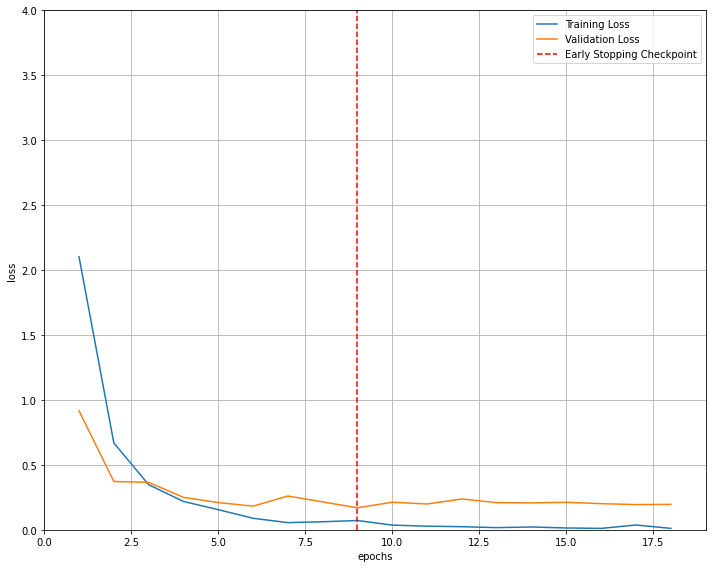

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

31
path >>  CheckPoints/VGG16_2


### Testing loop

In [ ]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [ ]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()


Avg testing loss: 0.18155, Avg testing accuracy : 94.66093444824219%



In [ ]:
from sklearn import metrics


In [ ]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [ ]:
performance_matrix(true,pred, 'macro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  0 33  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  6  0  1  0  0  0  1
   0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  2  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 

In [ ]:
performance_matrix(true,pred, 'micro')

Confusion Matrix:
 [[36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  0 33  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  6  0  1  0  0  0  1
   0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  2  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 

In [ ]:
performance_matrix(true,pred, None)

Confusion Matrix:
 [[36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  0 33  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  6  0  1  0  0  0  1
   0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  2  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 

In [ ]:
performance_matrix(true,pred, "weighted")

Confusion Matrix:
 [[36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  0 33  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  6  0  1  0  0  0  1
   0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  2  0  1  0  0  0  0
   1  0  0  0  0  0  0]
 

In [ ]:
count

62

In [ ]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

62

In [ ]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
!ls

 ArSL_Journal_alexnet_SGD_001_freezing.ipynb   CM_alexnet_4
 ArSL_Journal_alexnet_SGD_001.ipynb	       CM_Resnet_18_1
 ArSL_Journal_alexnet_SGD_01_freezing.ipynb    CM_Resnet_18_2
 ArSL_Journal_alexnet_SGD_01.ipynb	       CM_Resnet_18_3
 ArSL_Journal_alexnet_VGG16_001.ipynb	       CM_VGG16_1
 ArSL_Journal_alexnet_VGG16_01.ipynb	      'Final Data Version'
 ArSL_Journal_Resnet18_1.ipynb		       images
 ArSL_Journal_Resnet18_2.ipynb		       loss_plot.png
 ArSL_Journal_Resnet18_SGD_01.ipynb	       __pycache__
 checkpoint.pt				       pytorchtools.py
 CheckPoints				       requirements.txt
 CM_alexnet_1				       runs
 CM_alexnet_3


### Print fault images

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


P_Waw_T_Jeem_0.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Jeem/Jeem_30.jpg
P_Dal_T_Thal_1.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Thal/thal_169.jpg
P_Zain_T_Reh_2.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Reh/Reh_99.jpeg
P_Jeem_T_Hah_3.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Hah/Hah_69.jpg
P_Yeh_T_Dad_4.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Dad/Dad_251.jpg
P_Alef_T_Ghain_5.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Ghain/Ghain_189.jpg
P_Qaf_T_Heh_6.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Heh/Heh_157.jpeg
P_Dad_T_Sad_7.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/J

<Figure size 1224x1224 with 0 Axes>

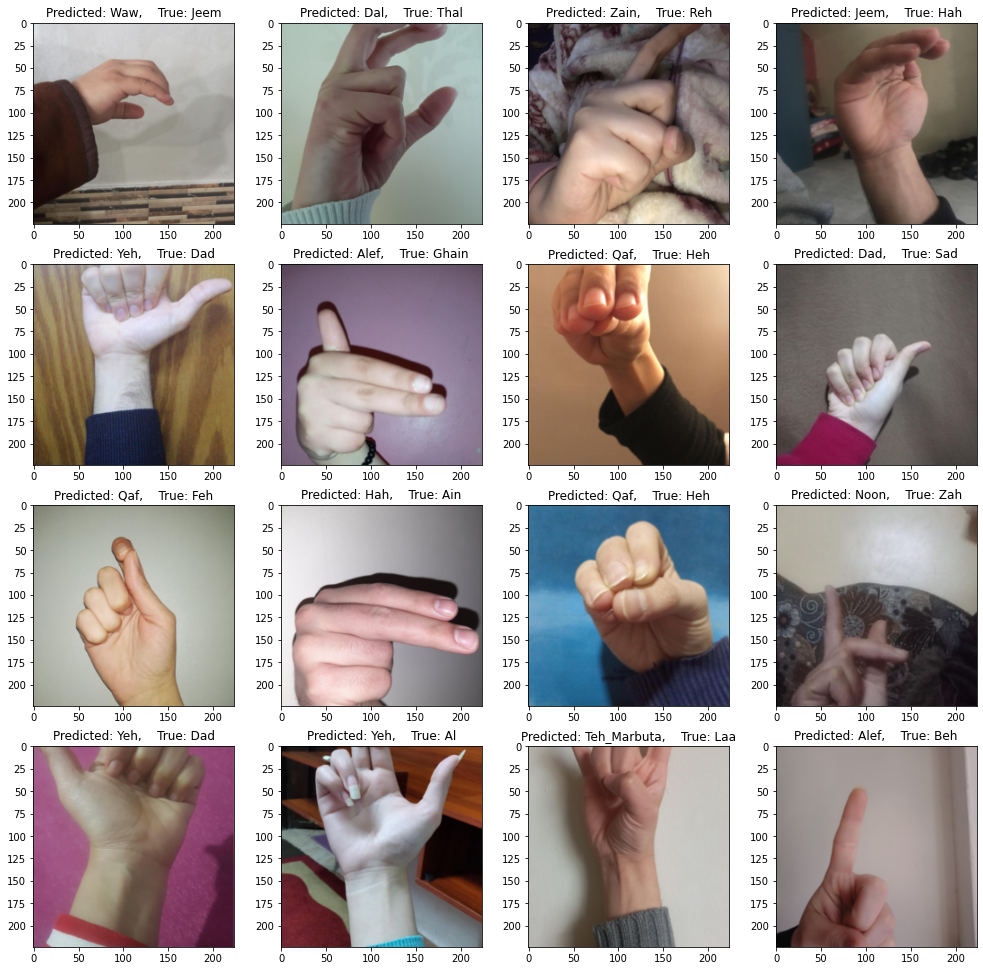

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


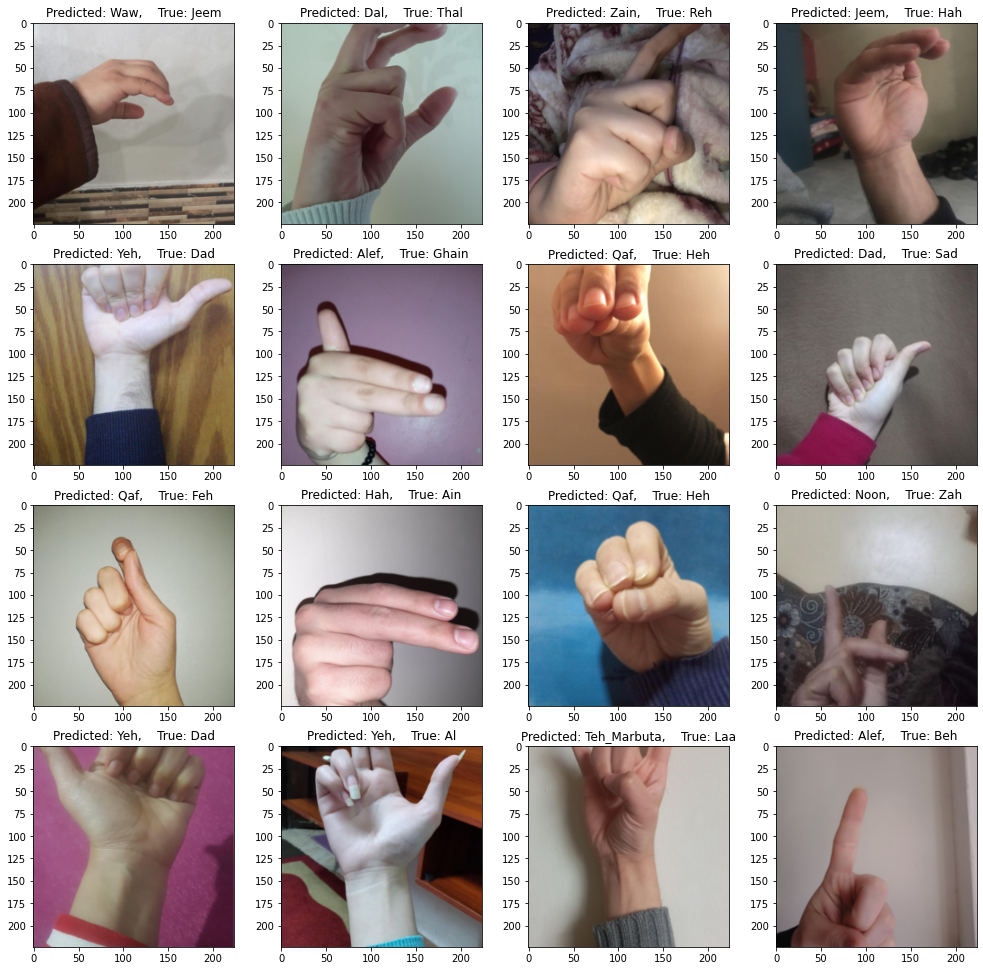

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


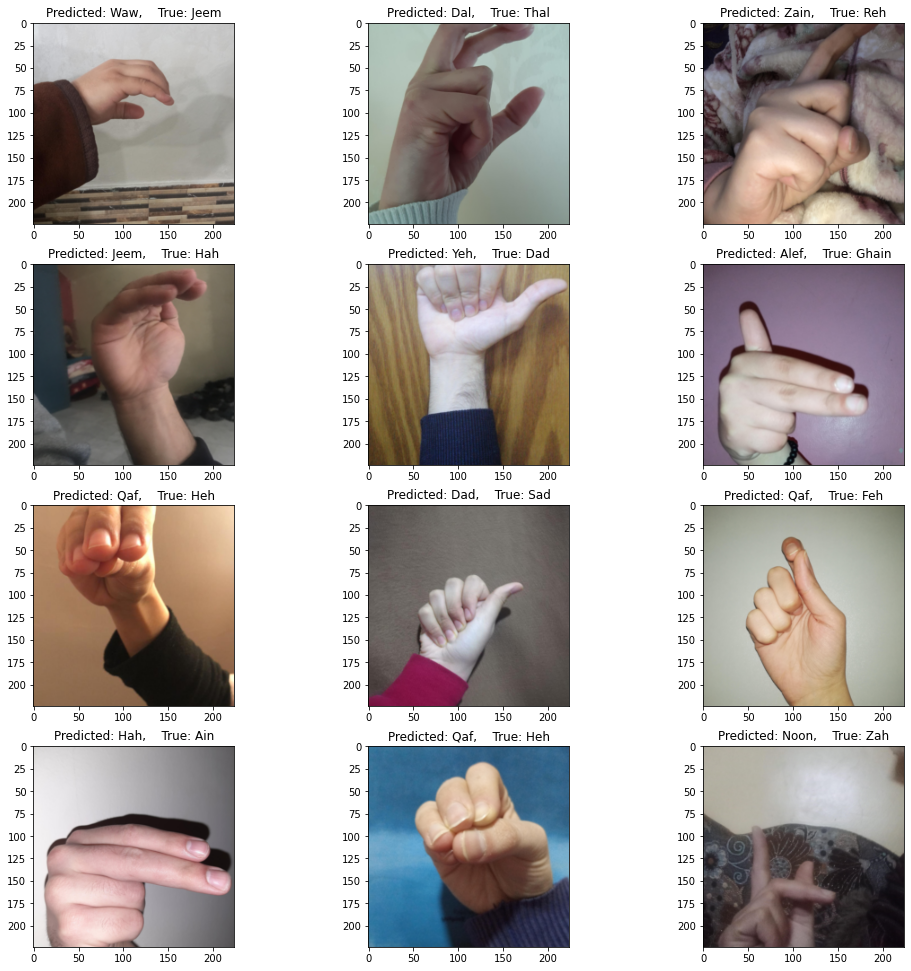

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


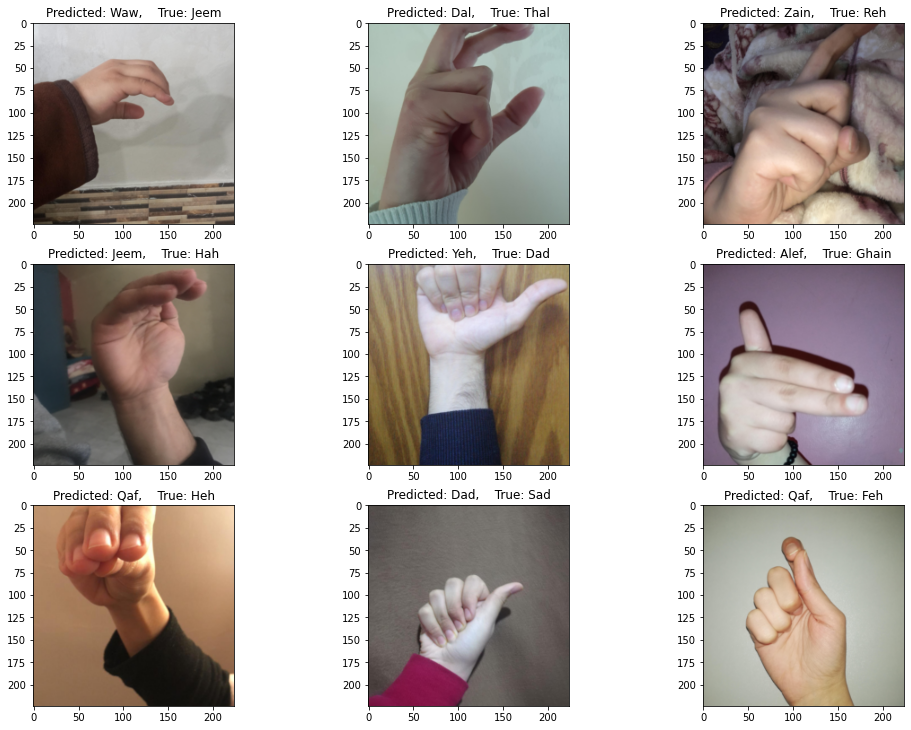

In [ ]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [ ]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

{'Ain': 0,
 'Al': 1,
 'Alef': 2,
 'Beh': 3,
 'Dad': 4,
 'Dal': 5,
 'Feh': 6,
 'Ghain': 7,
 'Hah': 8,
 'Heh': 9,
 'Jeem': 10,
 'Kaf': 11,
 'Khah': 12,
 'Laa': 13,
 'Lam': 14,
 'Meem': 15,
 'Noon': 16,
 'Qaf': 17,
 'Reh': 18,
 'Sad': 19,
 'Seen': 20,
 'Sheen': 21,
 'Tah': 22,
 'Teh': 23,
 'Teh_Marbuta': 24,
 'Thal': 25,
 'Theh': 26,
 'Waw': 27,
 'Yeh': 28,
 'Zah': 29,
 'Zain': 30}

In [ ]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [ ]:
idx_to_class_dic

{0: 'Ain',
 1: 'Al',
 2: 'Alef',
 3: 'Beh',
 4: 'Dad',
 5: 'Dal',
 6: 'Feh',
 7: 'Ghain',
 8: 'Hah',
 9: 'Heh',
 10: 'Jeem',
 11: 'Kaf',
 12: 'Khah',
 13: 'Laa',
 14: 'Lam',
 15: 'Meem',
 16: 'Noon',
 17: 'Qaf',
 18: 'Reh',
 19: 'Sad',
 20: 'Seen',
 21: 'Sheen',
 22: 'Tah',
 23: 'Teh',
 24: 'Teh_Marbuta',
 25: 'Thal',
 26: 'Theh',
 27: 'Waw',
 28: 'Yeh',
 29: 'Zah',
 30: 'Zain'}

In [ ]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [ ]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [ ]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [ ]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


Confusion matrix, without normalization
[[36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  2  0  0]
 [ 0  0  0  0  0 33  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  6  0  1  0  0  0  1
   0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 34  0  0  0  0  0  0  0  2  0  1  0  0  0  0
   1

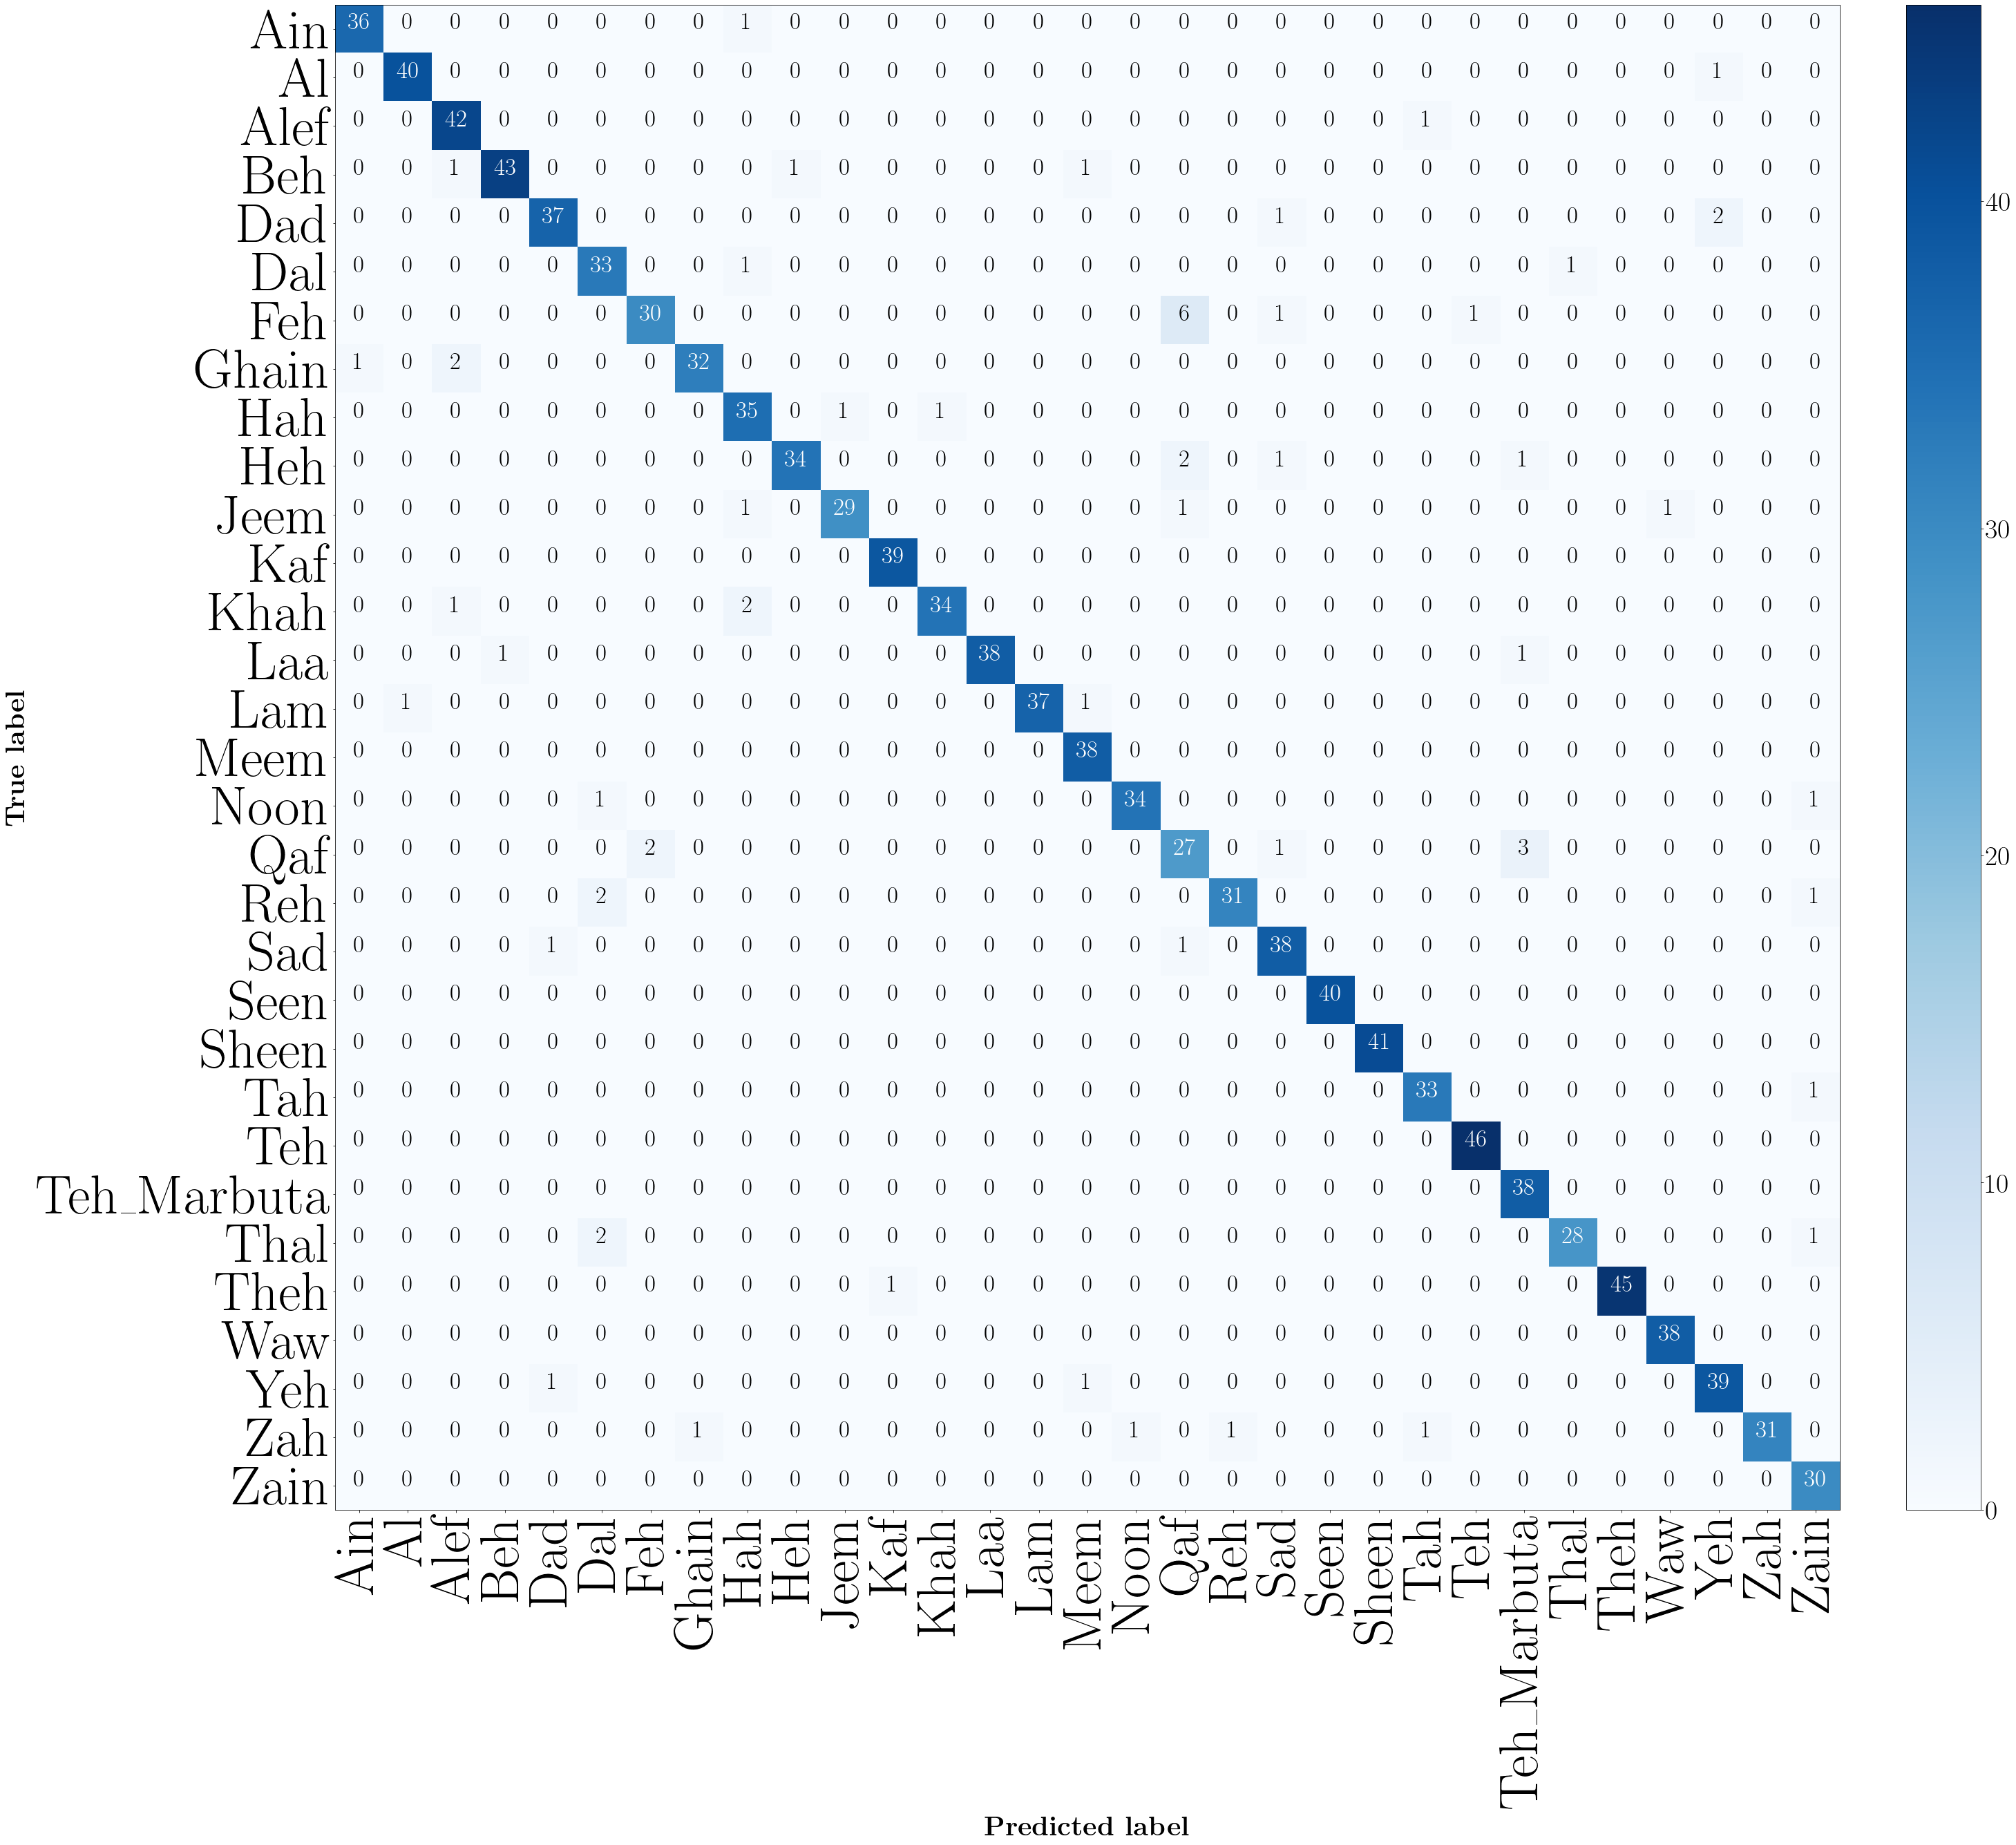

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
